In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization, Reshape, Flatten
from tensorflow.keras.models import Model, Sequential
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
file_path = '/content/Battery_1_Features.csv'
real_data = pd.read_csv(file_path)

In [3]:
# Normalize the real data for GAN training
real_data_normalized = (real_data - real_data.min()) / (real_data.max() - real_data.min())

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Get the shape of the real data
data_shape = real_data.shape[1]

In [4]:
# Define the generator model
def build_generator():
    model = Sequential([
        Dense(128, input_dim=100),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(data_shape, activation='tanh')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [5]:
# Define the discriminator model
def build_discriminator():
    model = Sequential([
        Dense(512, input_shape=(data_shape,)),
        LeakyReLU(alpha=0.2),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [6]:
# Build and compile the GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

In [7]:
# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

In [8]:
# Train the GAN model with accuracy recording at 100 interval epochs and early stopping
def train_gan_with_accuracy_plot(epochs, batch_size, interval):
    batch_count = real_data_normalized.shape[0] // batch_size
    d_losses = []
    g_losses = []
    d_accuracies = []
    epochs_list = []

    for epoch in range(epochs):
        for _ in range(batch_count):
            # Get a random set of real data
            idx = np.random.randint(0, real_data_normalized.shape[0], batch_size)
            real = real_data_normalized.iloc[idx].values

            # Generate fake data
            noise = np.random.normal(0, 1, (batch_size, 100))
            fake = generator.predict(noise)

            # Train the discriminator
            discriminator.trainable = True
            d_loss_real = discriminator.train_on_batch(real, np.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch(fake, np.zeros((batch_size, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator
            noise = np.random.normal(0, 1, (batch_size, 100))
            discriminator.trainable = False
            g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))

        # Record the losses for plotting at specified interval
        if (epoch + 1) % interval == 0:
            epochs_list.append(epoch + 1)
            d_losses.append(d_loss[0])
            g_losses.append(g_loss)
            d_accuracies.append(100 * d_loss[1])
            print(f"{epoch + 1}/{epochs}, D Loss: {d_loss[0]}, D Acc: {100 * d_loss[1]}, G Loss: {g_loss}")

        # Early stopping condition
        if g_loss < 1 and 0.6 <= d_loss[0] <= 1.2 and 45 <= d_loss[1] * 100 <= 55:
            print(f"Early stopping at epoch {epoch + 1} due to reaching ideal values")
            break

    return epochs_list, d_losses, g_losses, d_accuracies

# Train the GAN with accuracy recording and early stopping
epochs_list, d_losses, g_losses, d_accuracies = train_gan_with_accuracy_plot(epochs=1000, batch_size=32, interval=20)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
60/1000, D Loss: 0.01288164290599525, D Acc: 100.0, G Loss: 4.509156227111816
1/1 [==============================] - 0s 34ms/step
80/1000, D Loss: 0.02437176462262869, D Acc: 100.0, G Loss: 5.283493995666504
1/1 [==============================] - 0s 24ms/step
100/1000, D Loss: 0.04665380762889981, D Acc: 98.4375, G Loss: 4.270296096801758
1/1 [==============================] - 0s 32ms/step
120/1000, D Loss: 0.08250769600272179, D Acc: 98.4375, G Loss: 4.494183540344238
1/1 [==============================] - 0s 32ms/step
140/1000, D Loss: 0.1288921982049942, D Acc: 96.875, G Loss: 4.514972686767578
1/1 [==============================] - 0s 35ms/step
160/1000, D Loss: 0.07754913344979286, D Acc: 98.4375, G Loss: 9.419259071350098
1/1 [==============================] - 0s 35ms/step
180/1000, D Loss: 0.4218482971191406, D Acc: 85.9375, G Loss: 3.1881885528564453
1/1 [=====================

In [9]:
# Generate synthetic data
noise = np.random.normal(0, 1, (real_data.shape[0], 100))
synthetic_data = generator.predict(noise)

37/37 [==============================] - 1s 6ms/step


In [10]:
# Denormalize the synthetic data
synthetic_data_denormalized = synthetic_data * (real_data.max().values - real_data.min().values) + real_data.min().values

# Convert synthetic data to DataFrame
synthetic_data_df = pd.DataFrame(synthetic_data_denormalized, columns=real_data.columns)

In [11]:
# Save synthetic data to CSV
synthetic_data_file_path = 'Synthetic_Battery_Data.csv'
synthetic_data_df.to_csv(synthetic_data_file_path, index=False)

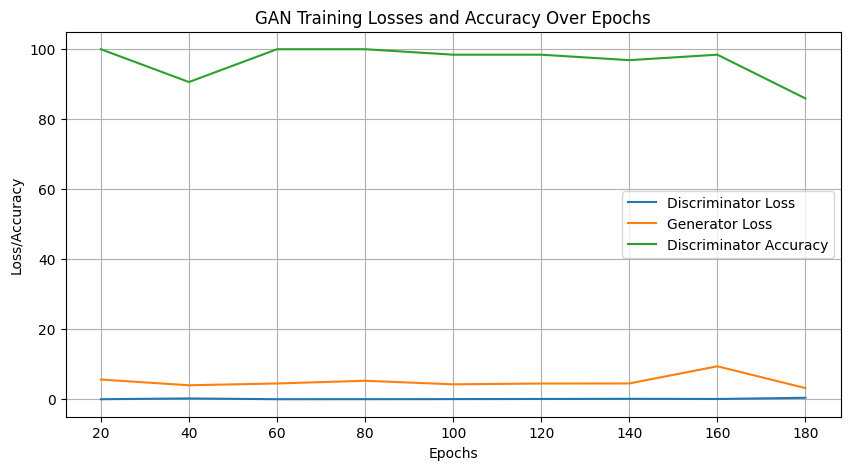

In [12]:
# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs_list, d_losses, label='Discriminator Loss')
plt.plot(epochs_list, g_losses, label='Generator Loss')
plt.plot(epochs_list, d_accuracies, label='Discriminator Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.title('GAN Training Losses and Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
# Function to plot comparison
def plot_comparison(real, synthetic, feature):
    plt.figure(figsize=(10, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    plt.hist(real[feature], bins=30, alpha=0.5, label='Real')
    plt.hist(synthetic[feature], bins=30, alpha=0.5, label='Synthetic')
    plt.title(f'Histogram of {feature}')
    plt.legend()

    # CDF
    plt.subplot(1, 2, 2)
    real_sorted = np.sort(real[feature])
    synthetic_sorted = np.sort(synthetic[feature])
    real_cdf = np.arange(1, len(real_sorted) + 1) / len(real_sorted)
    synthetic_cdf = np.arange(1, len(synthetic_sorted) + 1) / len(synthetic_sorted)
    plt.plot(real_sorted, real_cdf, label='Real')
    plt.plot(synthetic_sorted, synthetic_cdf, label='Synthetic')
    plt.title(f'CDF of {feature}')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
# Select features to compare
features_to_compare = real_data.columns[:]  # Change as needed

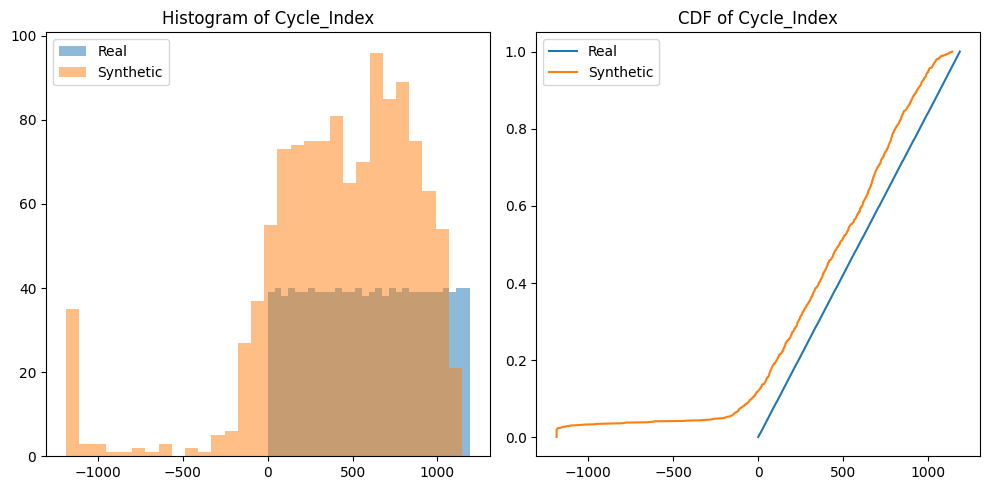

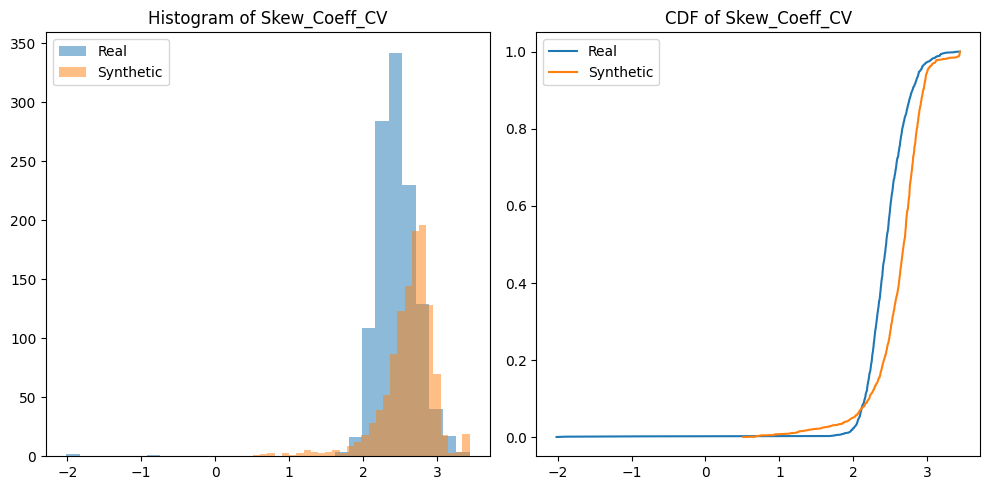

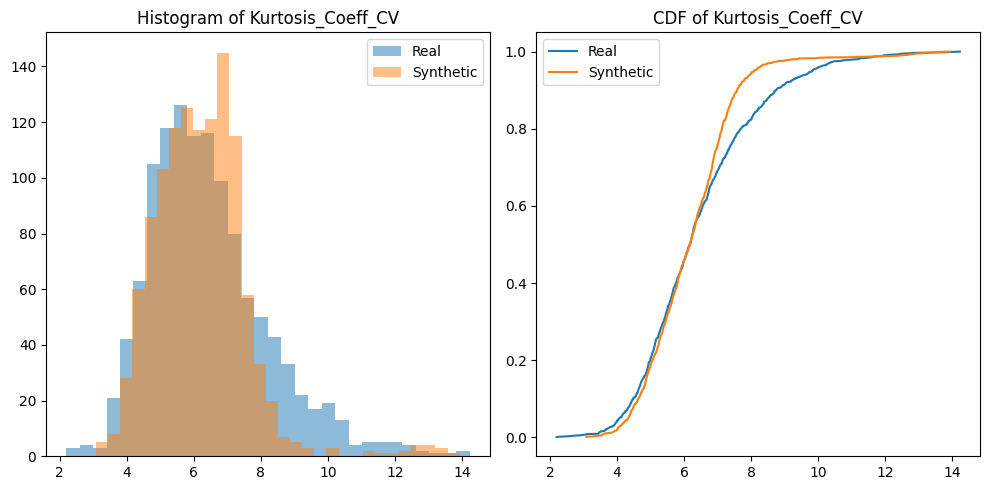

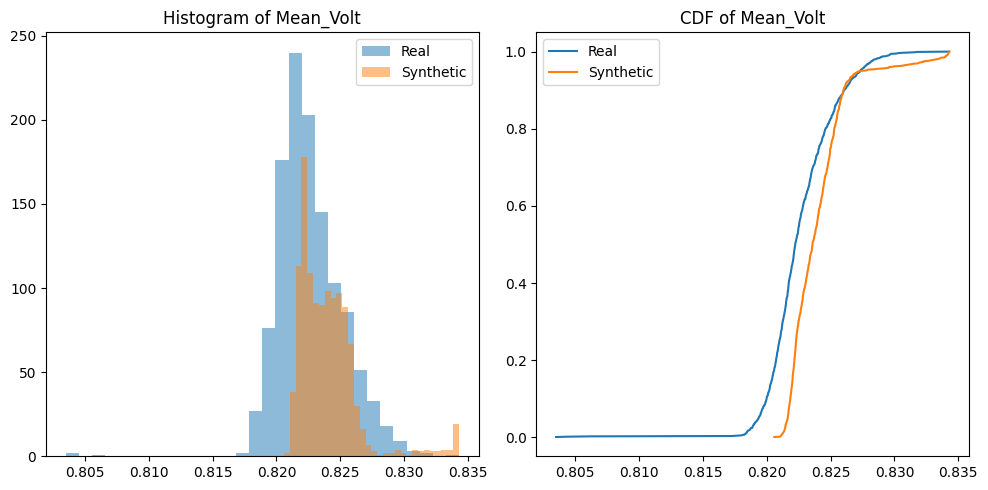

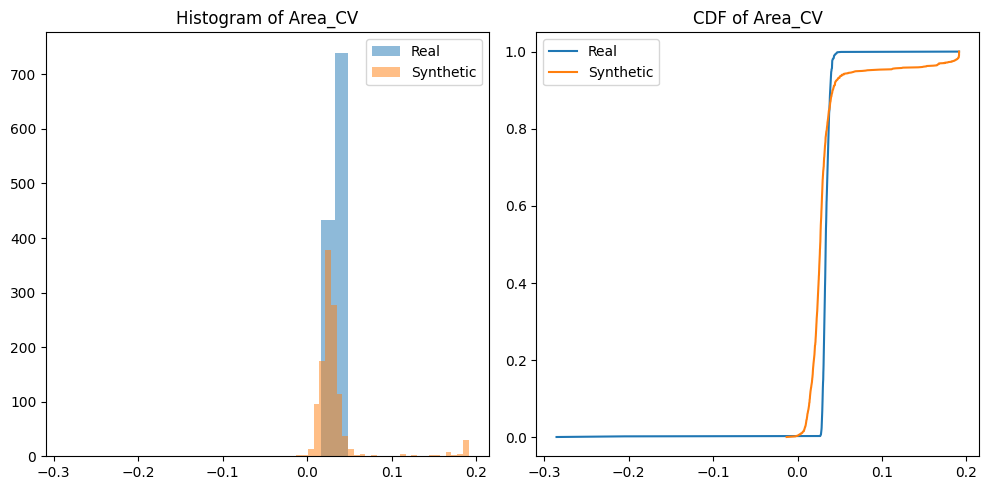

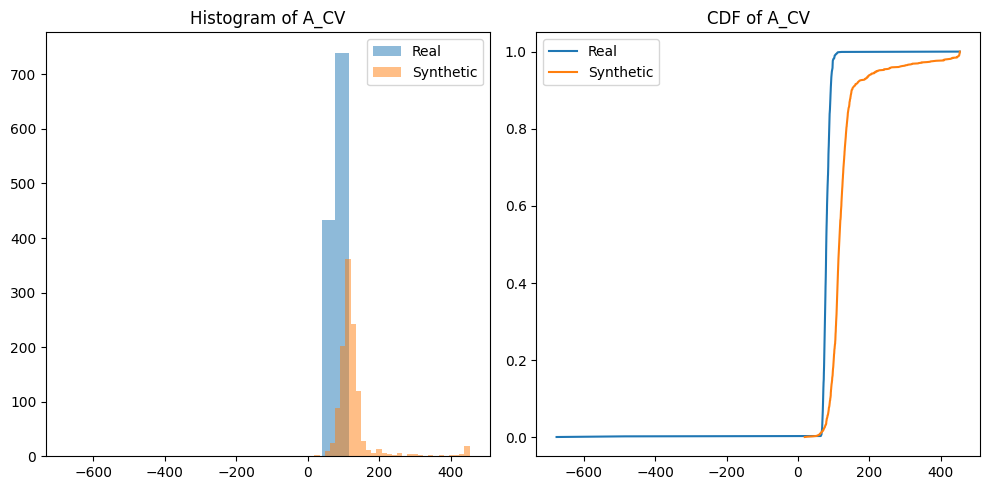

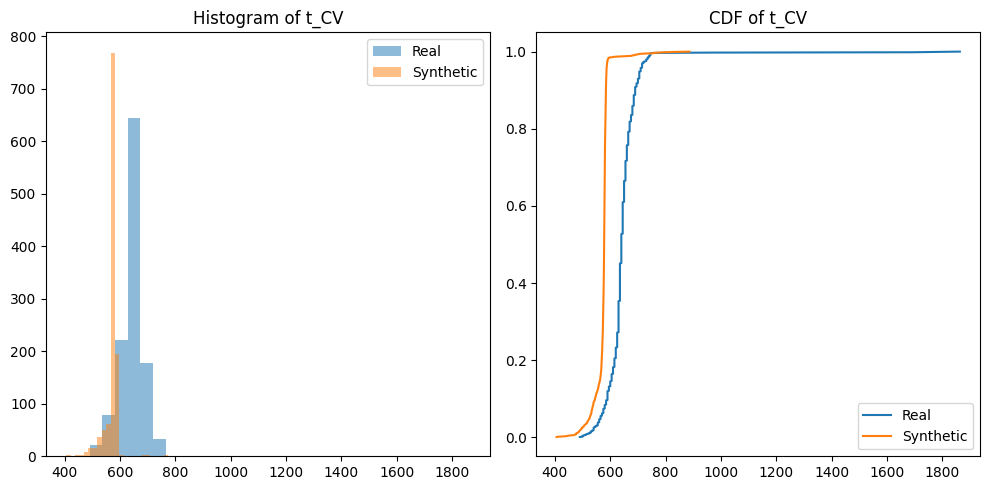

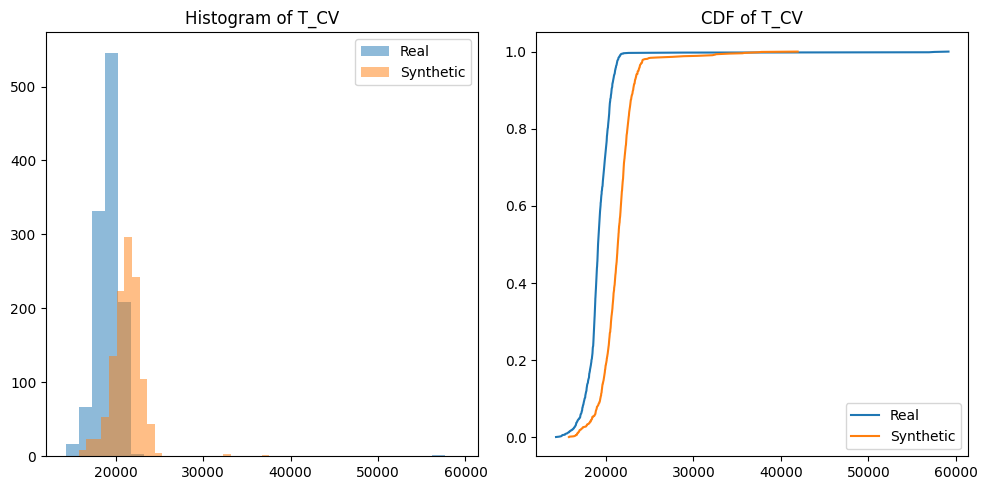

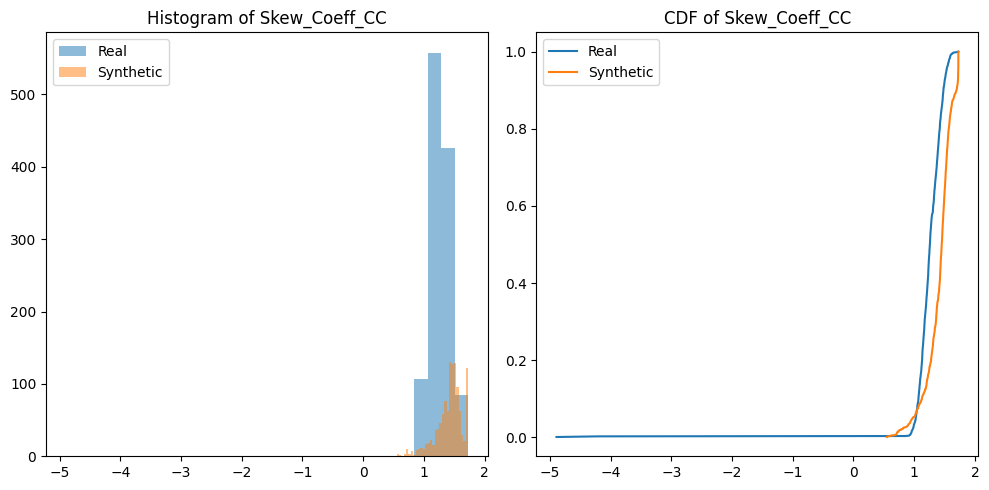

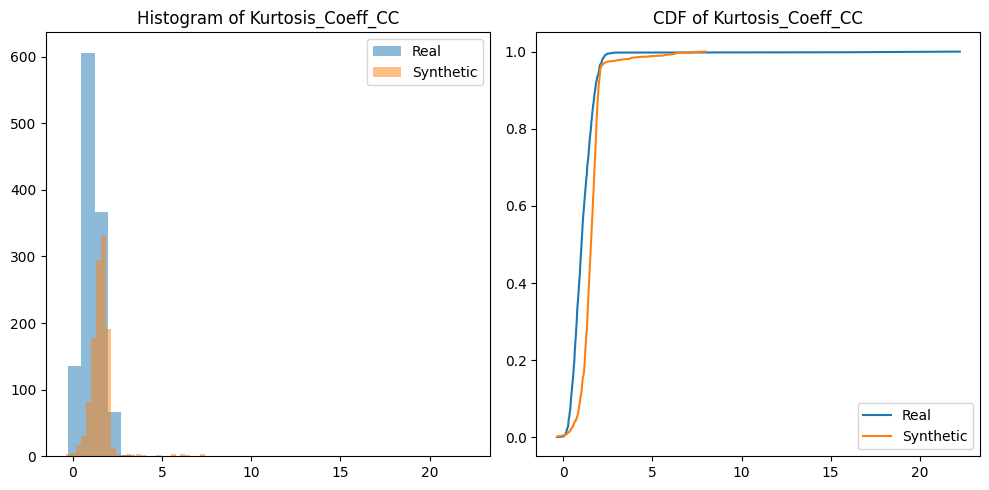

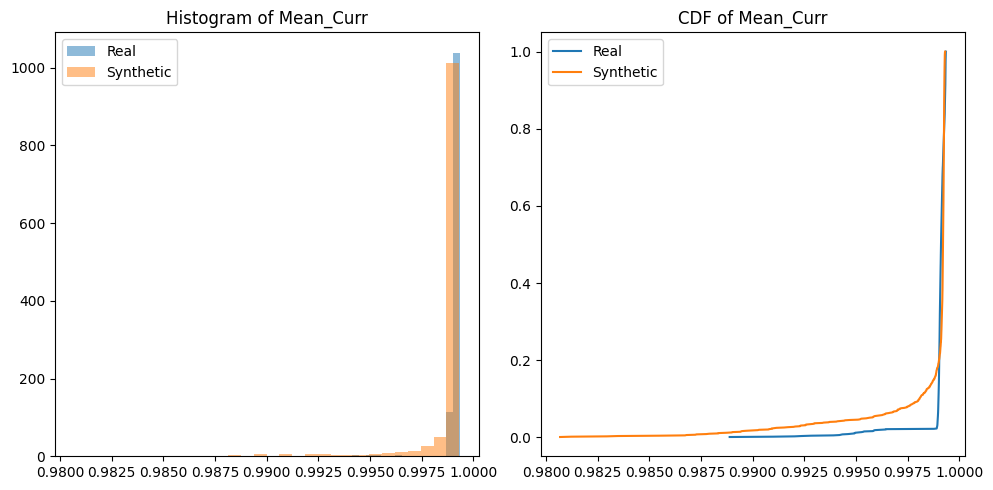

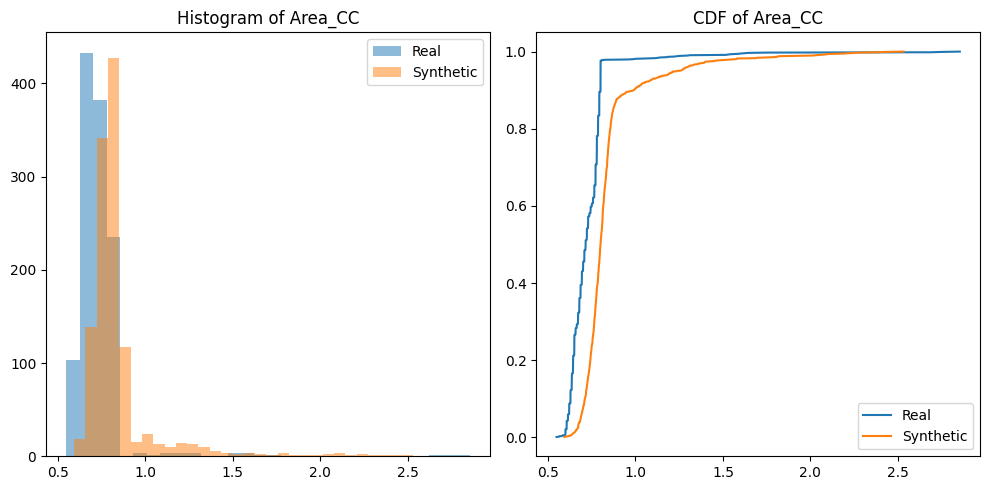

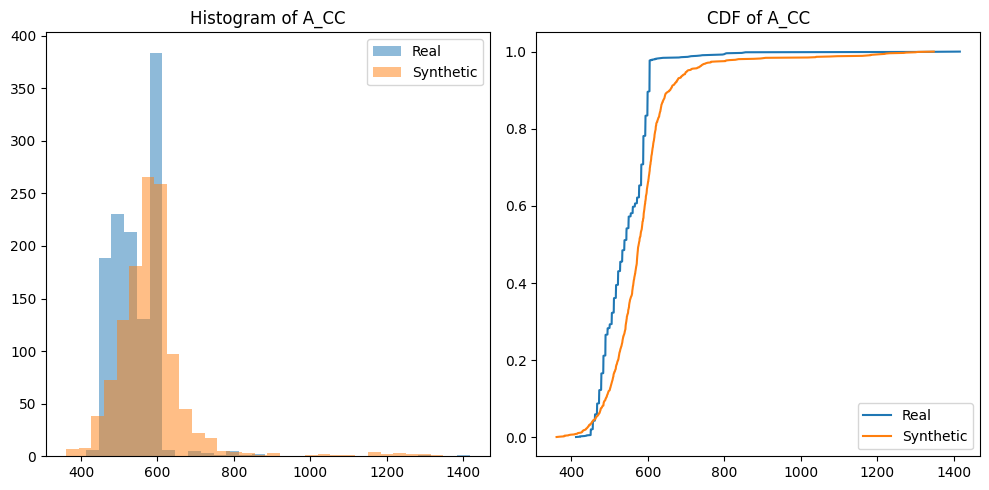

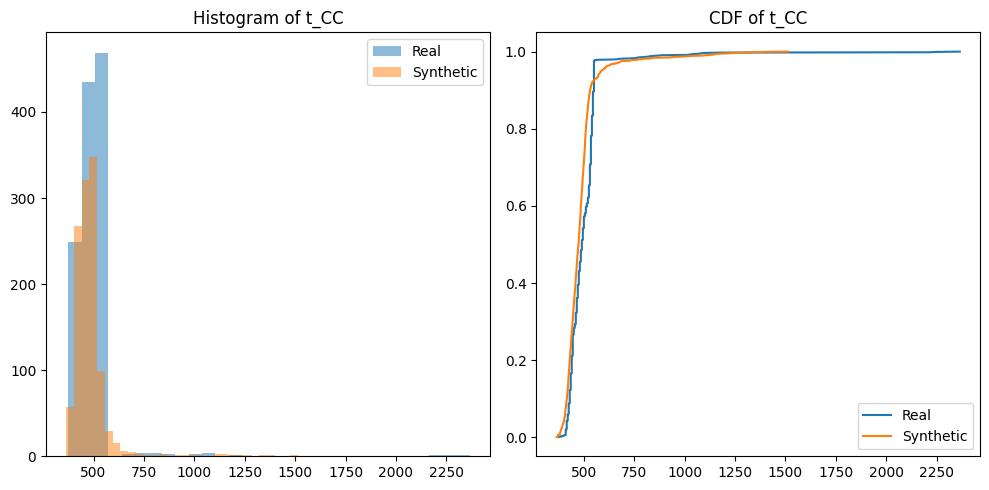

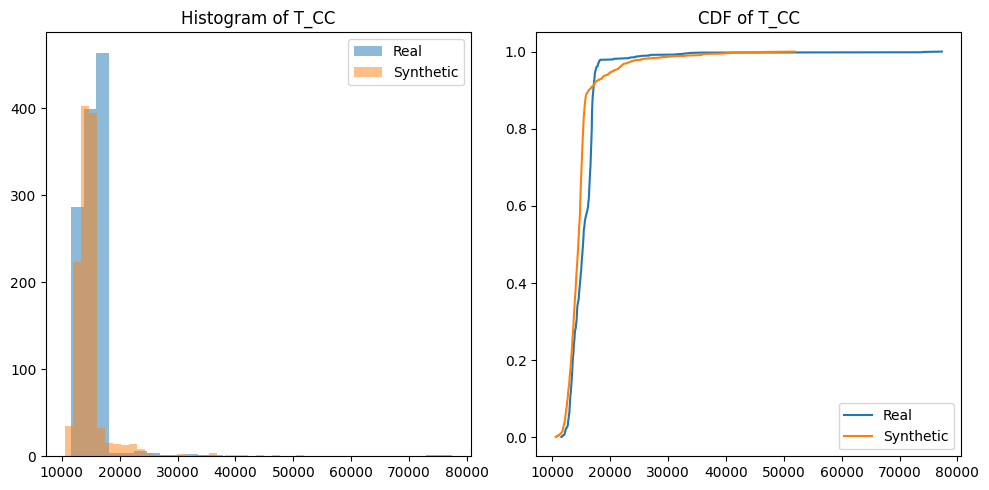

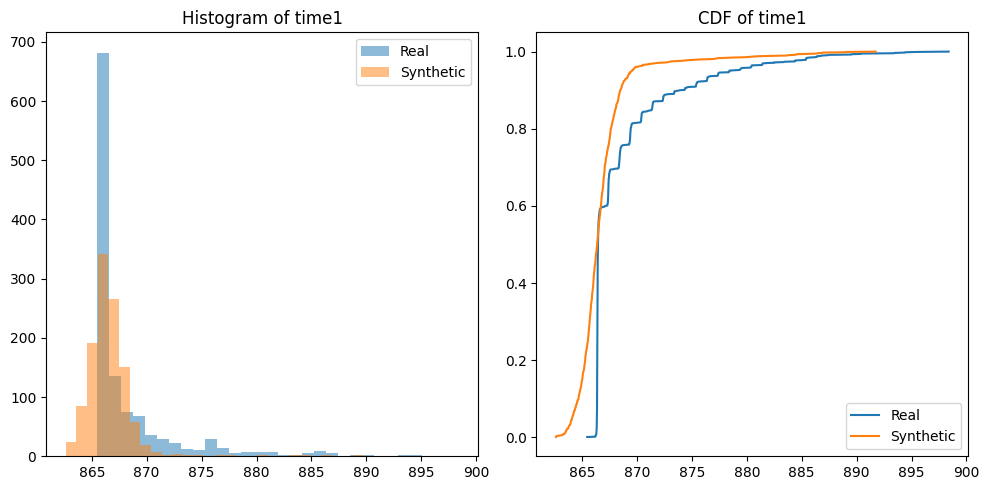

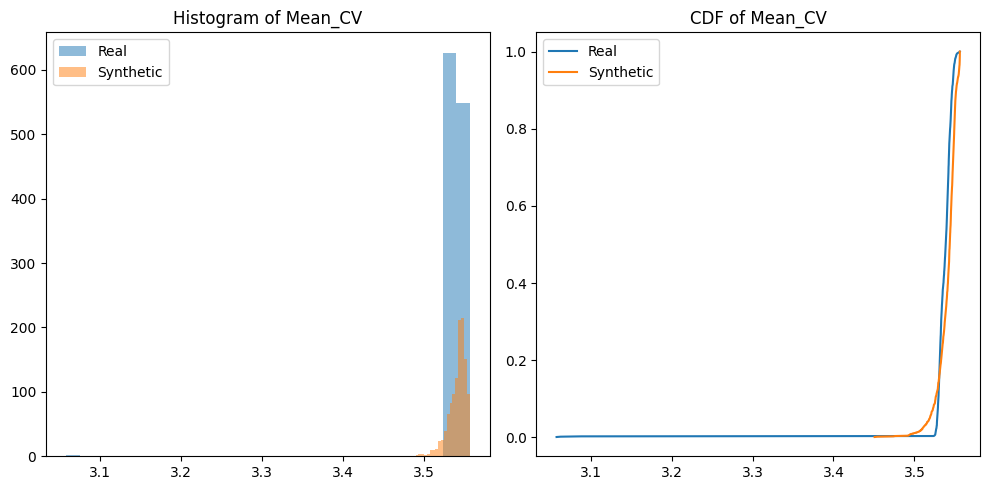

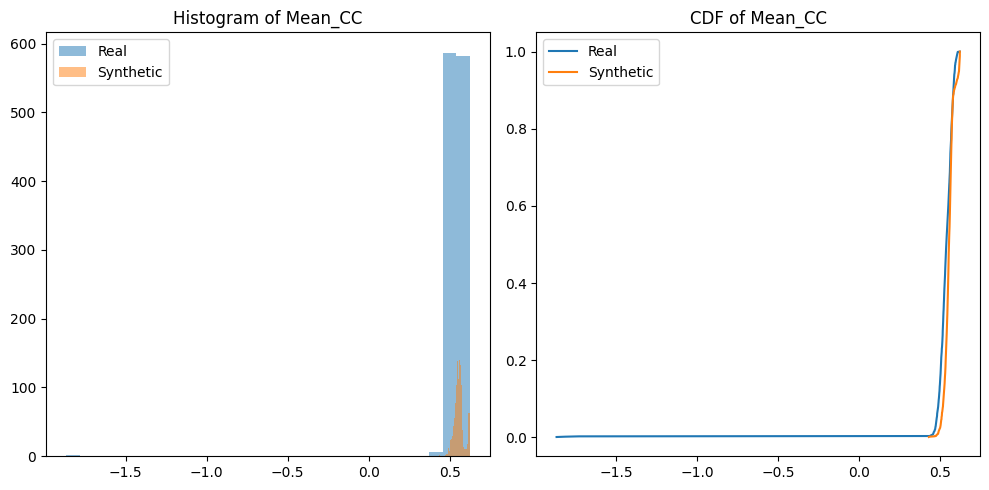

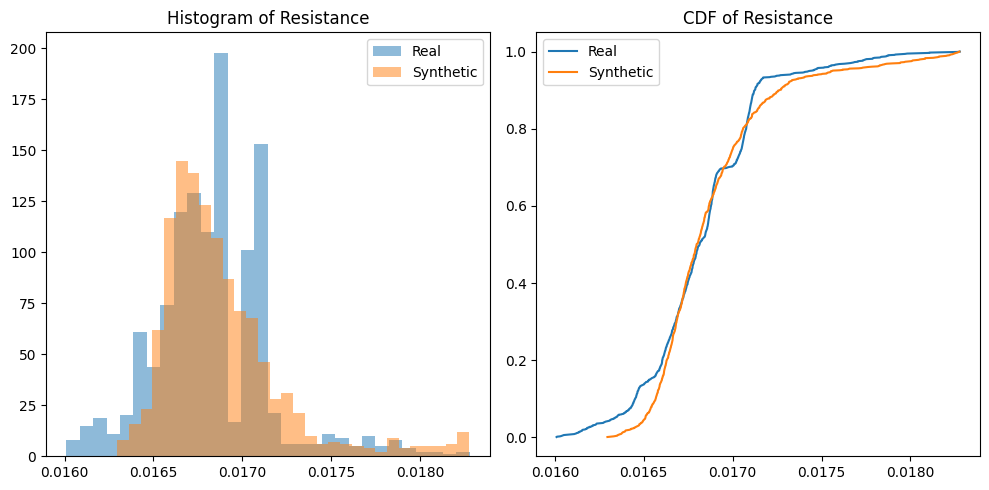

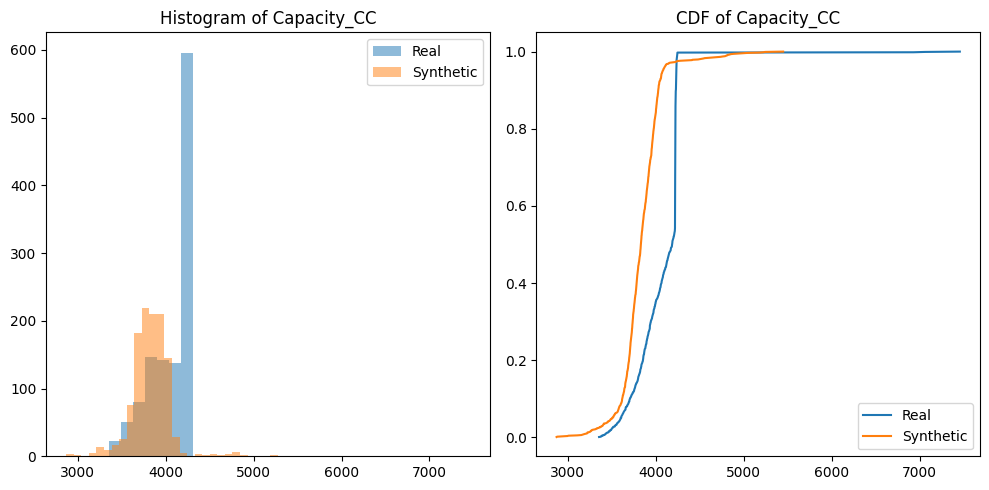

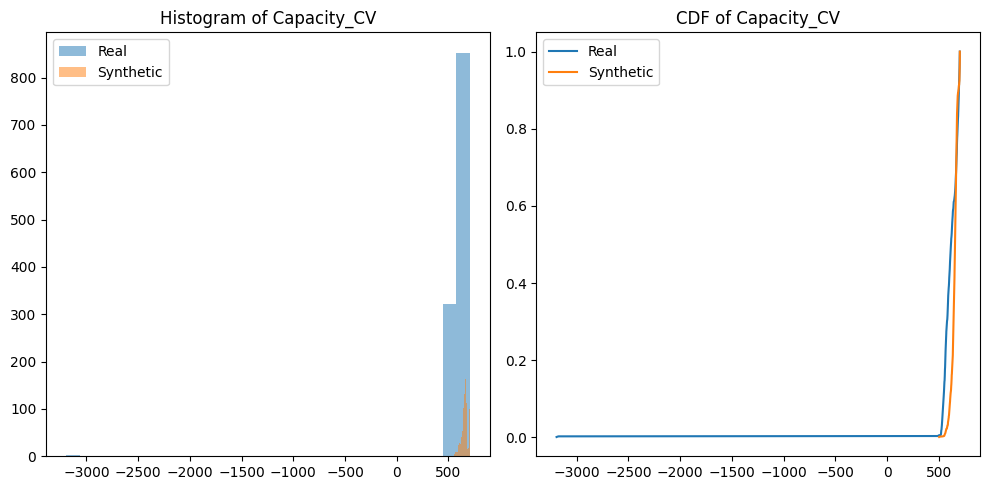

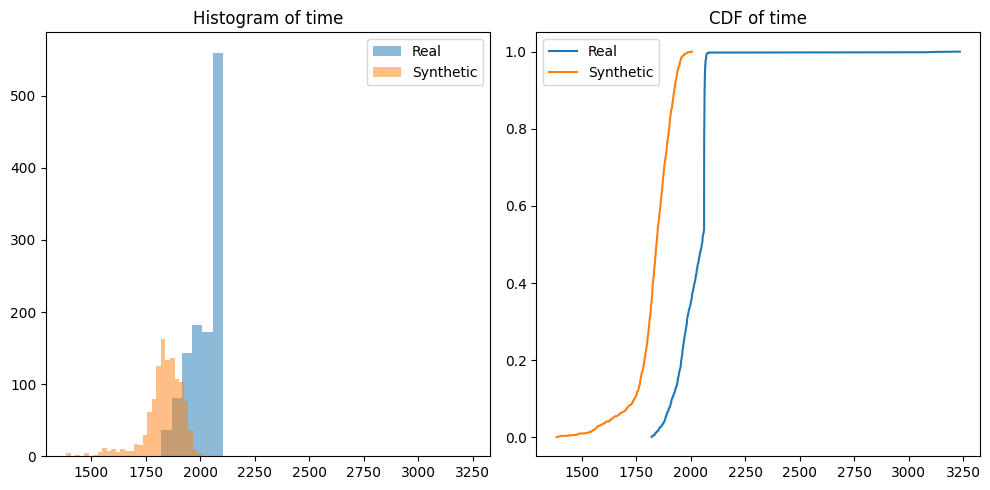

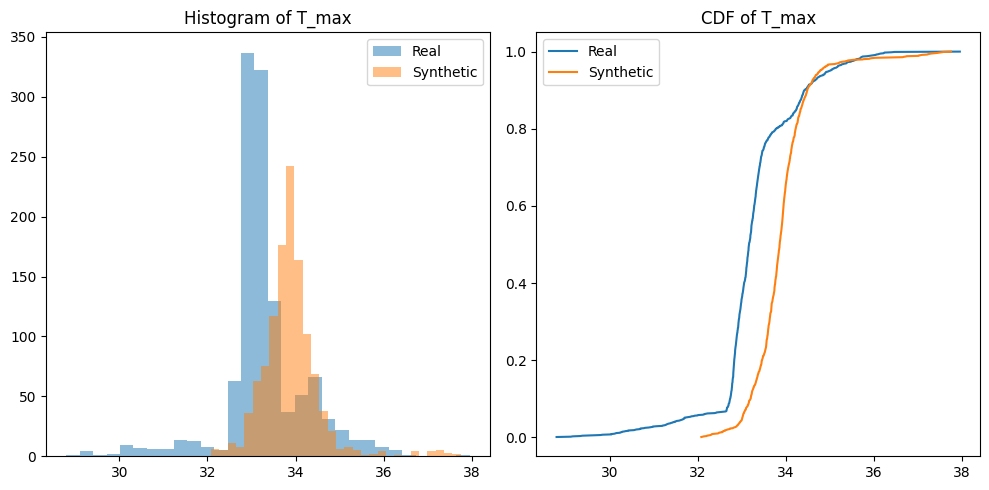

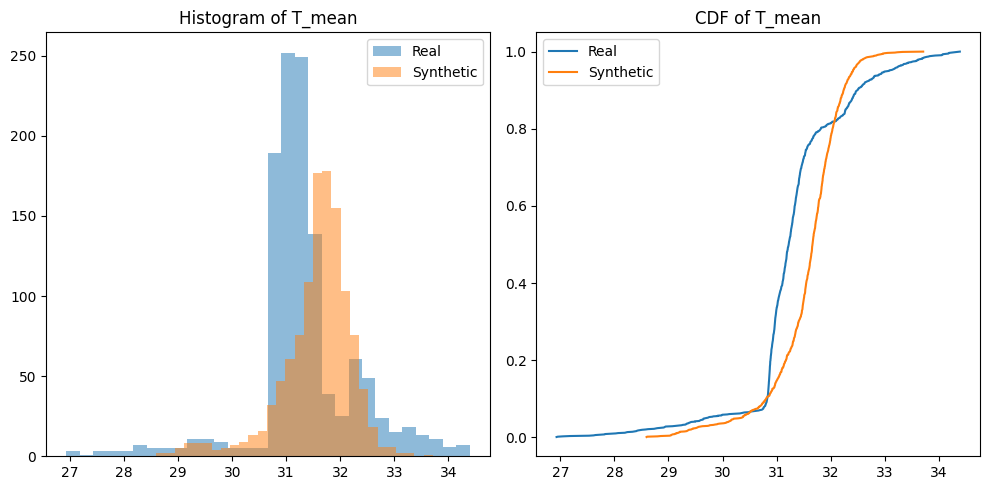

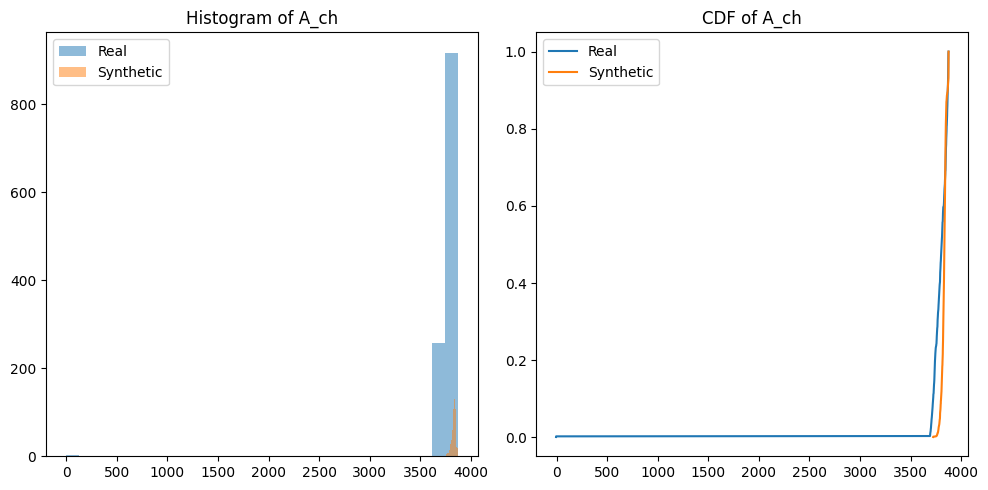

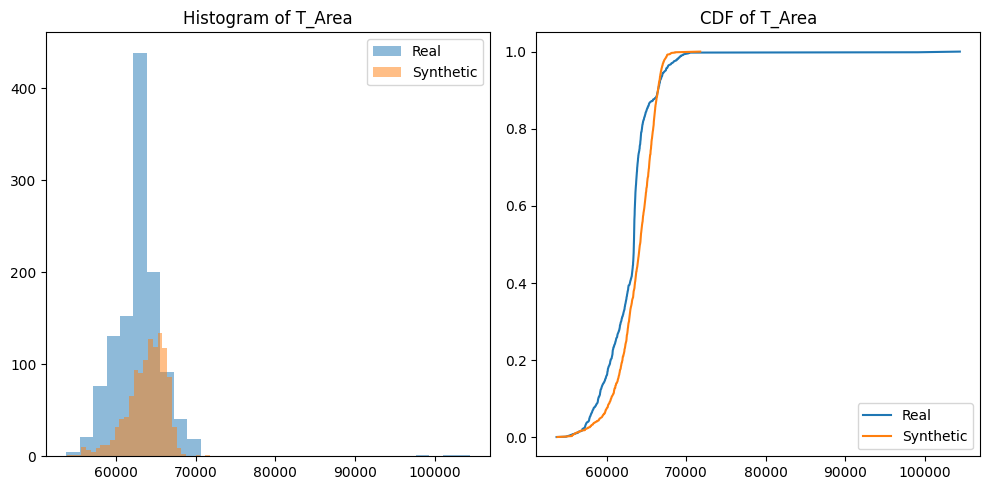

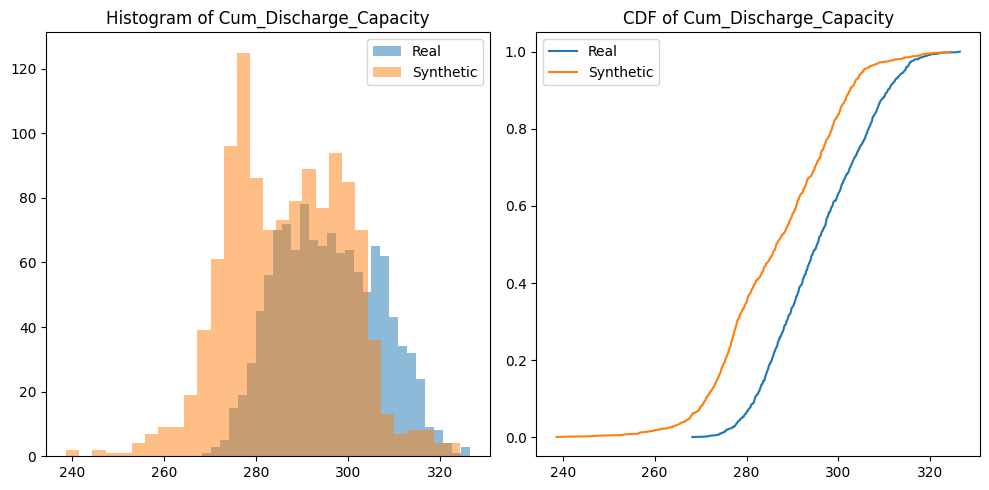

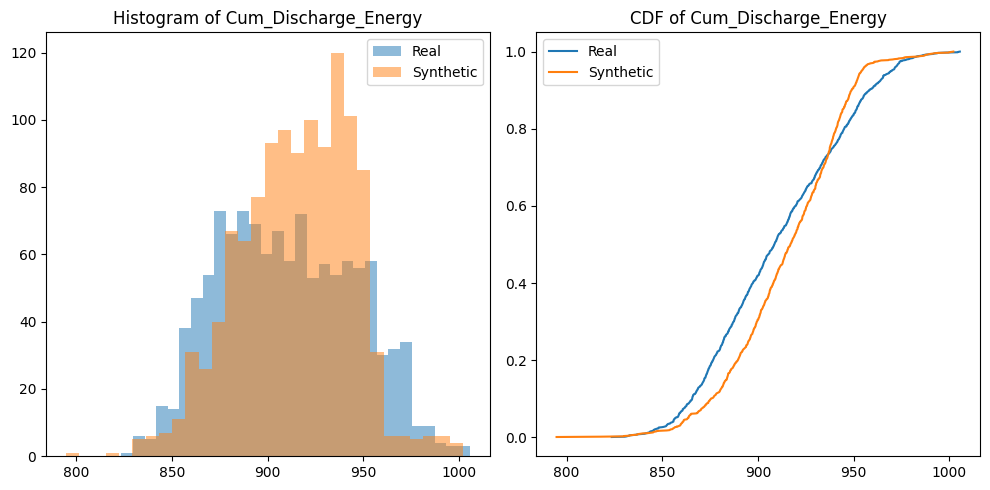

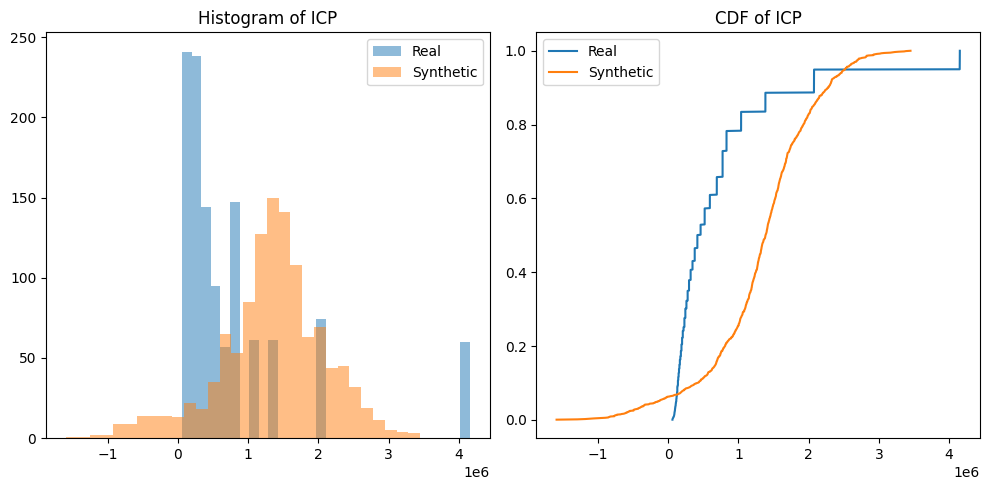

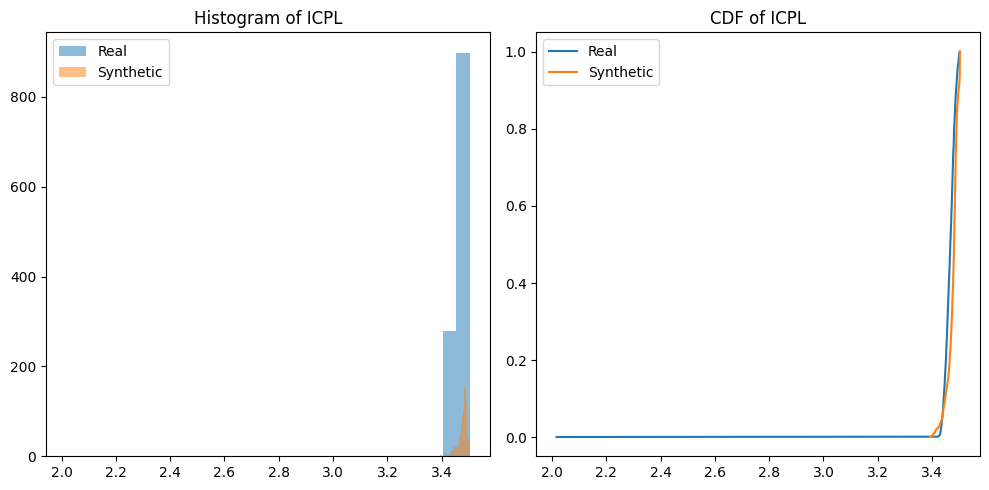

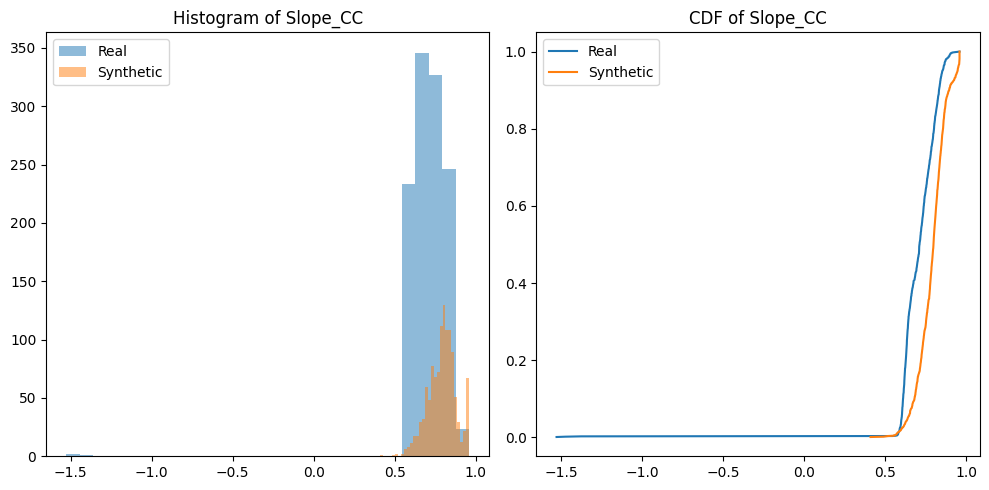

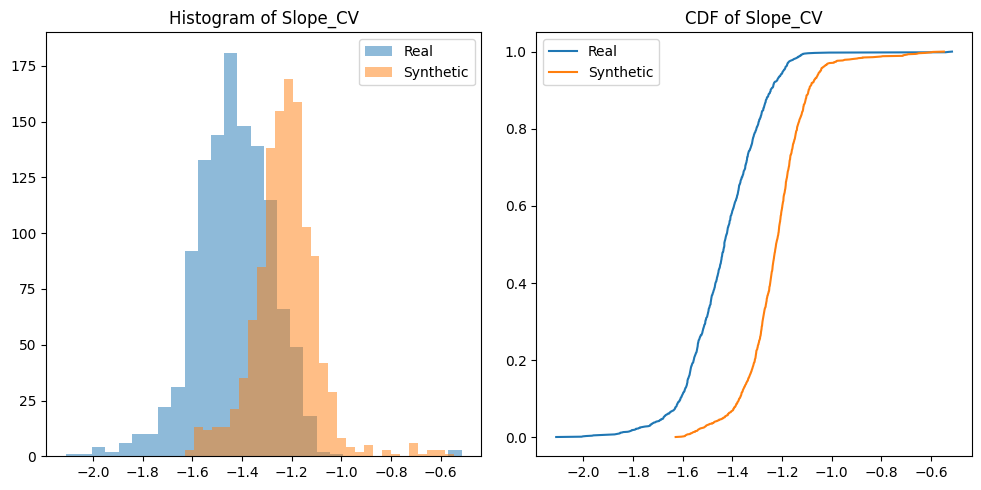

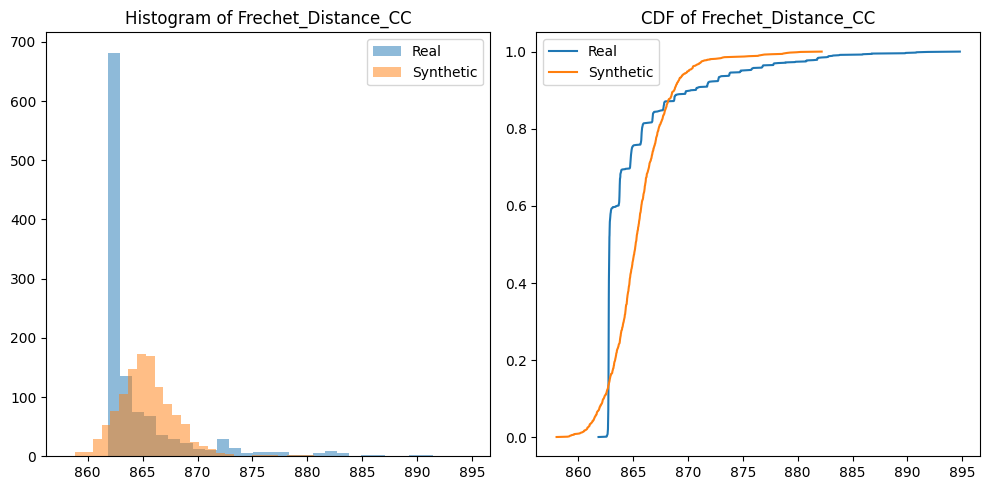

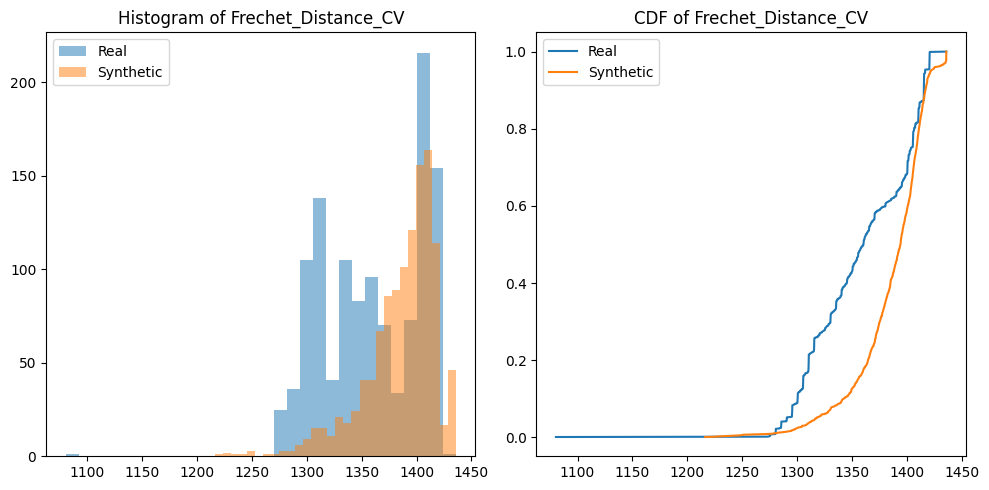

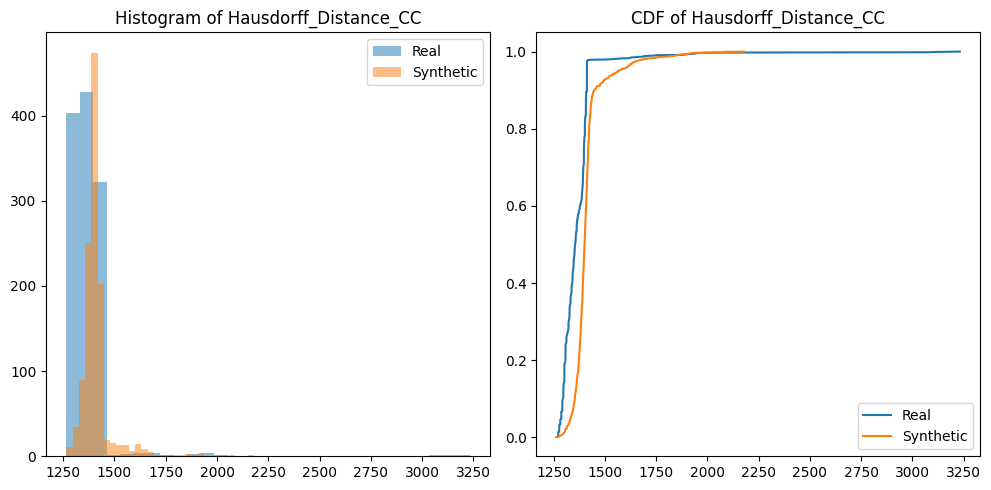

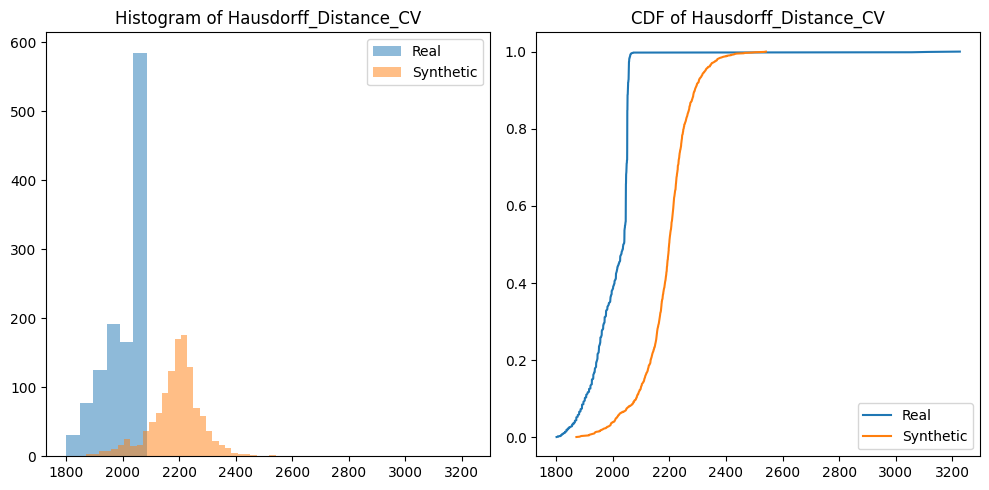

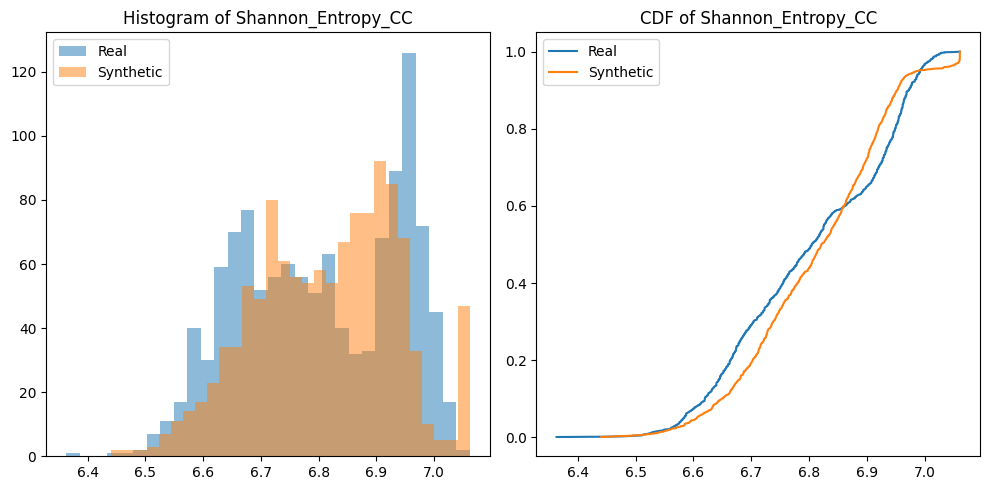

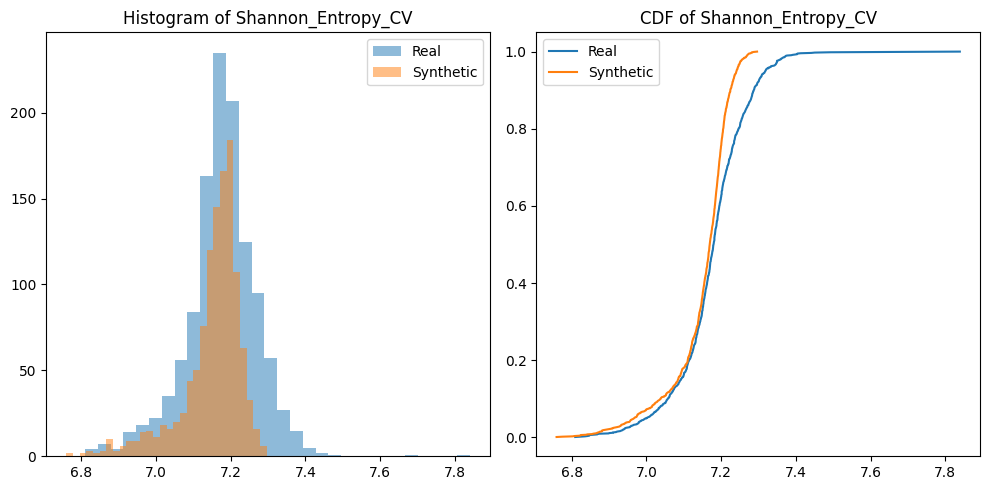

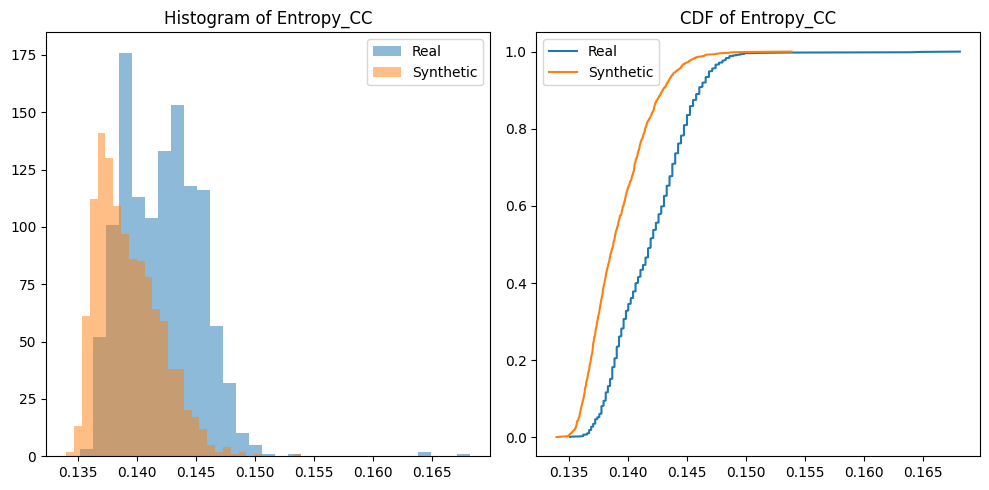

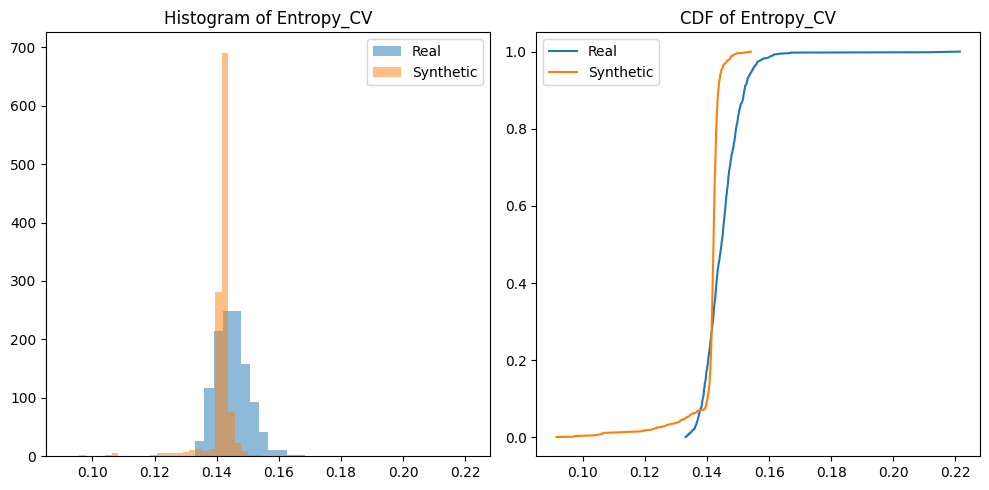

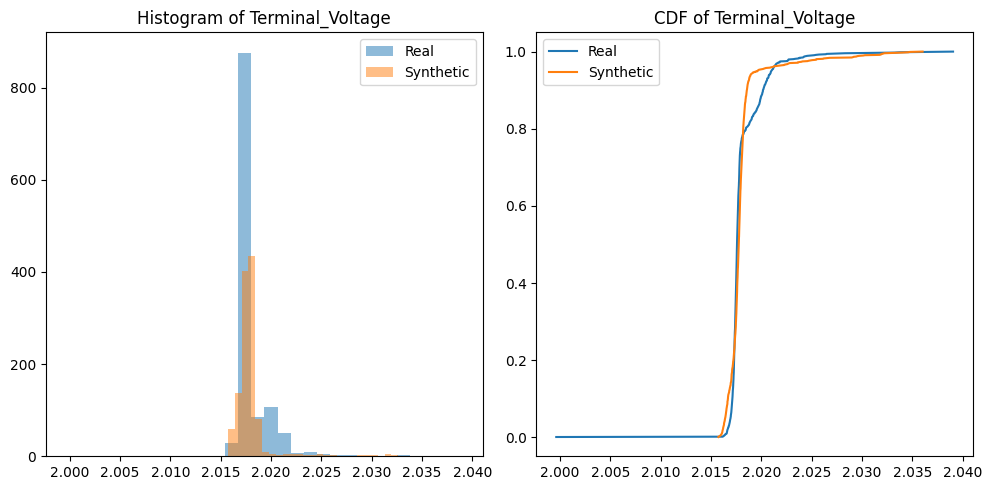

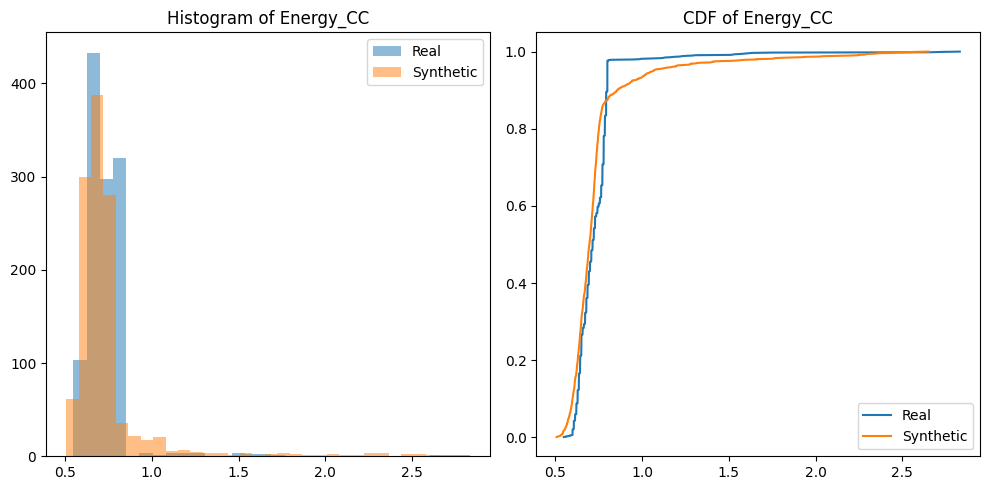

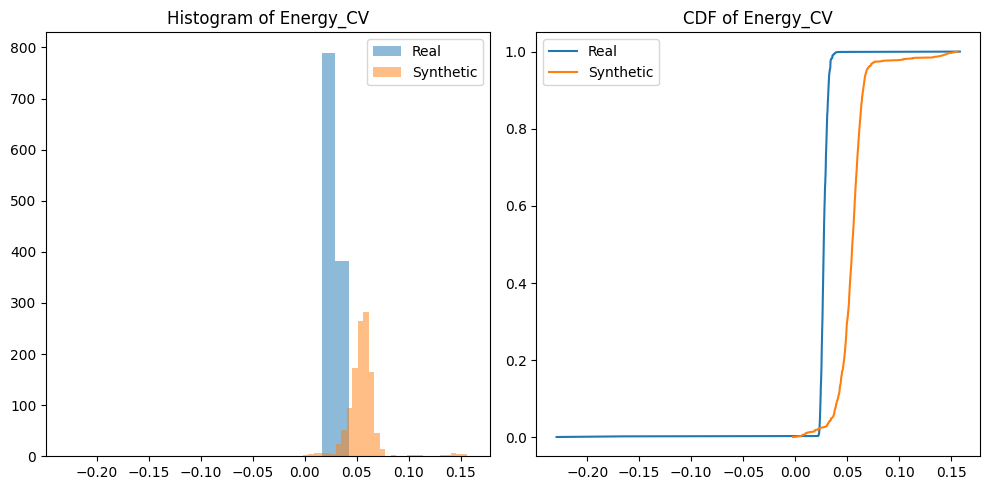

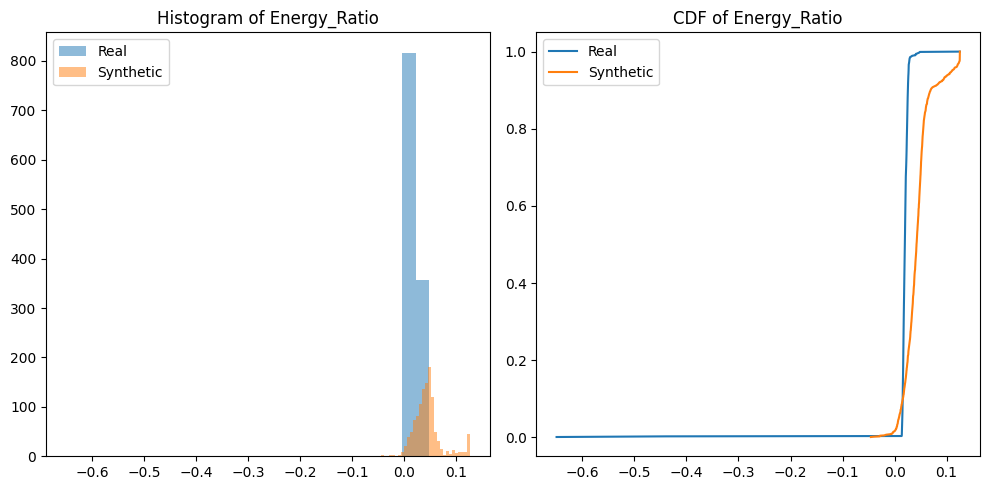

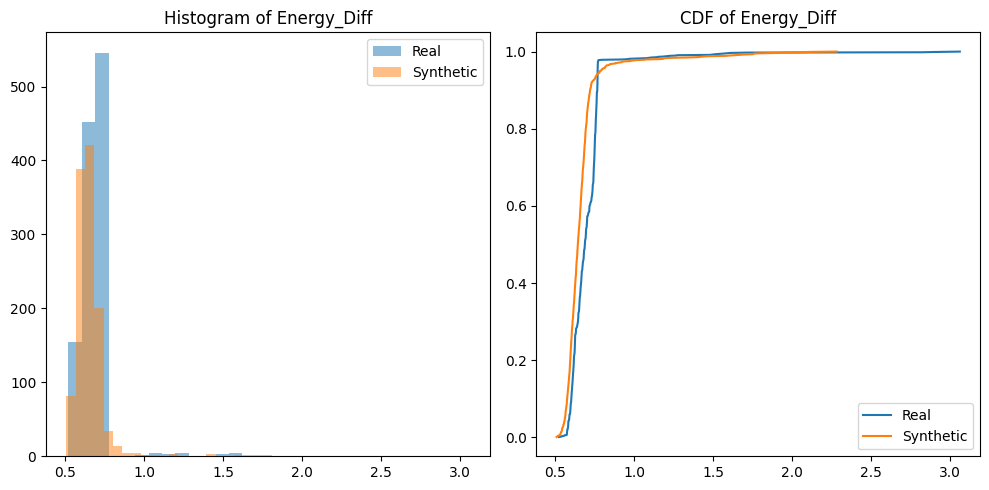

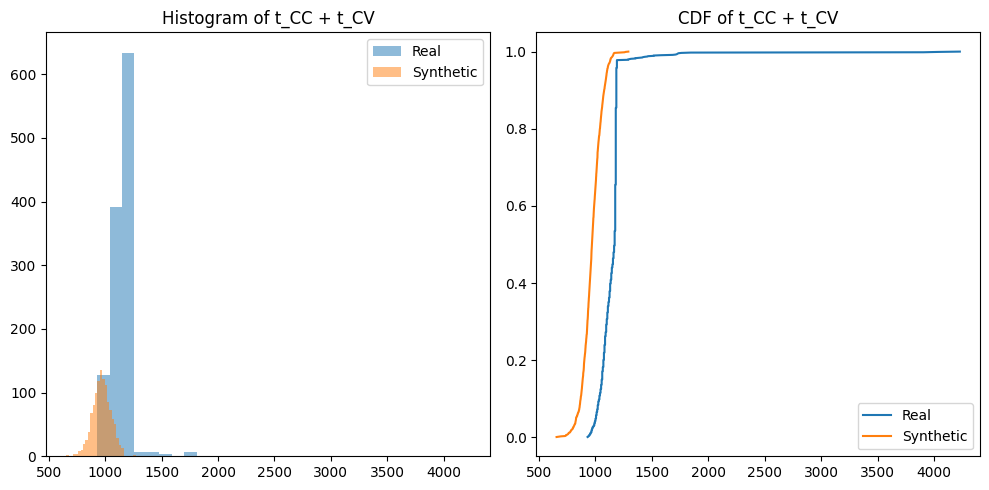

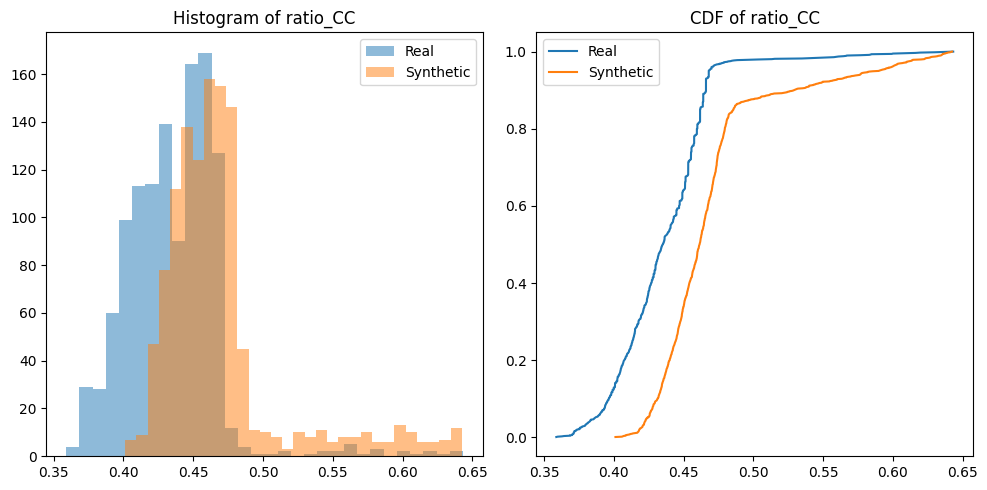

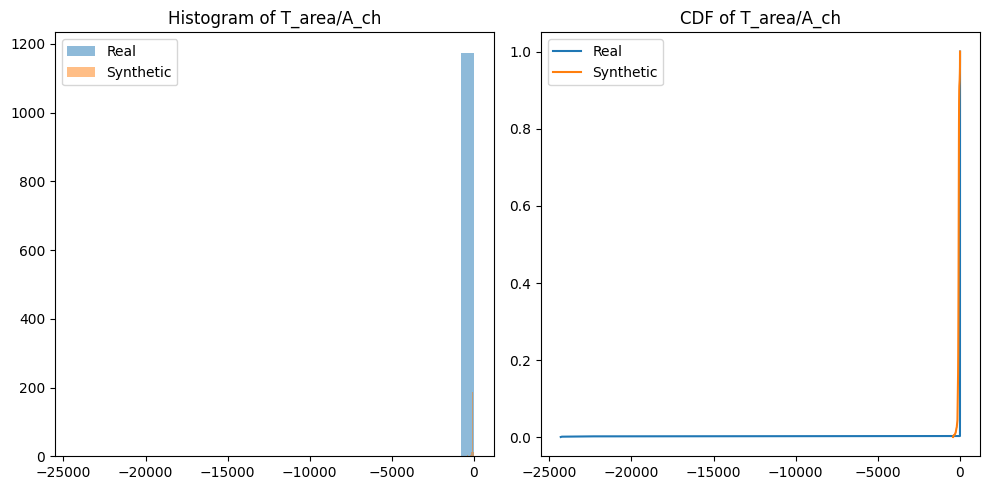

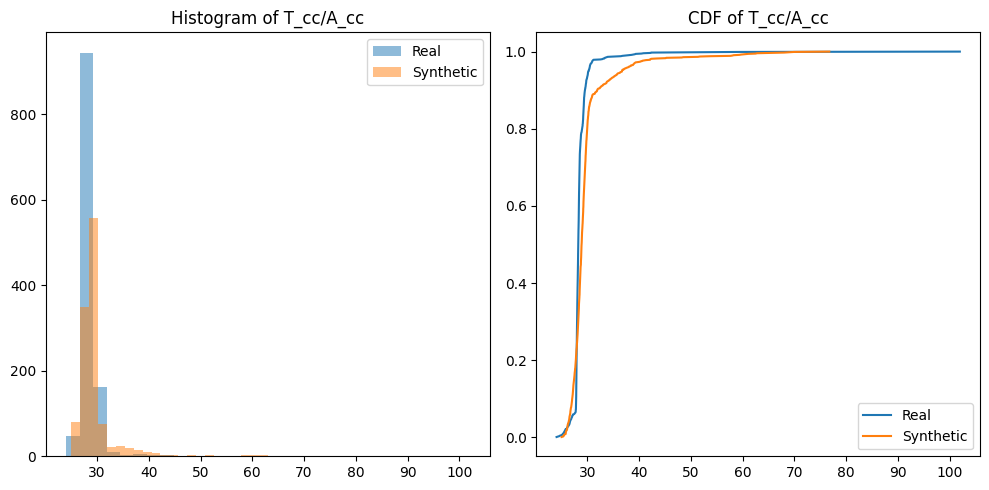

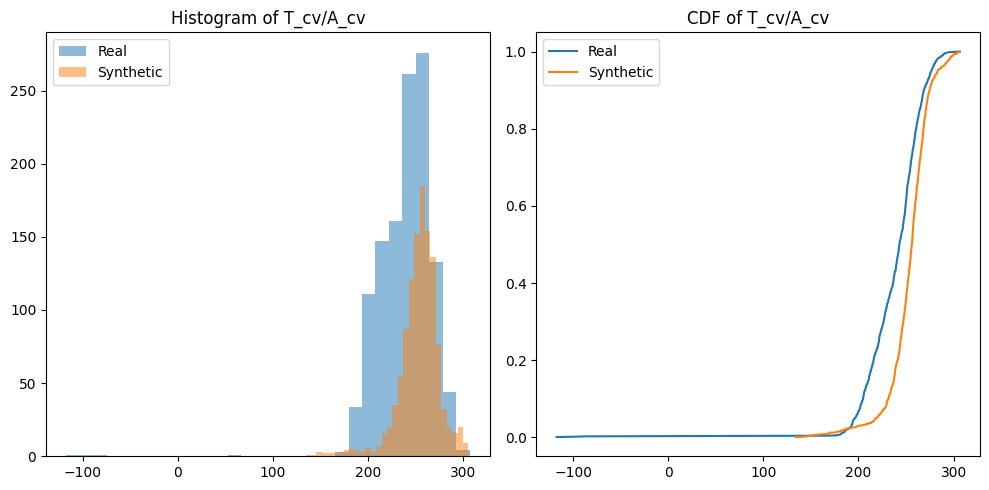

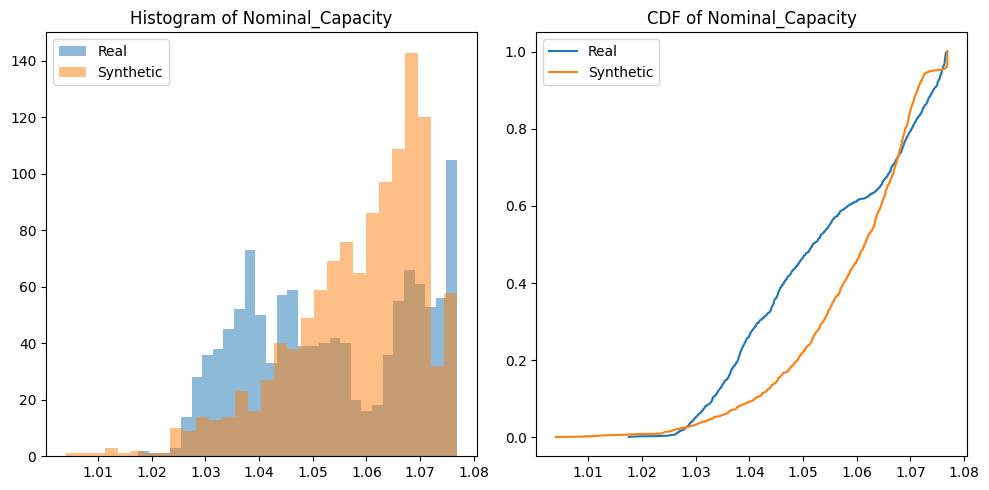

In [15]:
# Plot comparison one by one
for feature in features_to_compare:
    plot_comparison(real_data, synthetic_data_df, feature)